In [17]:
import json
import numpy as np
import nltk
import os
import matplotlib.pyplot as plt

In [18]:
print("Preparing summaries...")
def get_avg_num_tokens(sentences):
    n_tokens = []
    for sentence in sentences:
        n_tokens += [len(nltk.word_tokenize(sentence))]
    return np.average(n_tokens)

def get_max_num_tokens(sentences):
    n_tokens = []
    for sentence in sentences:
        n_tokens += [len(nltk.word_tokenize(sentence))]
    return np.max(n_tokens)

base_dir = "./untuned/"

task_summaries = []
for fname in os.listdir("./untuned"):
    with open(base_dir + fname, 'r') as f:
        examples_and_explanations = json.load(f)
    prompts = {}

    examples = [ex for fewshot_examples in examples_and_explanations["fewshot_examples"] for ex in fewshot_examples]
    task_summaries += [{
        "fname": fname,
        "avg_num_tokens": {
            "task_prefix": get_avg_num_tokens([examples_and_explanations["task_prefix"]]),
            "zeroshot_descriptions": get_avg_num_tokens(examples_and_explanations["zeroshot_descriptions"]),
            "zeroshot_nondescriptions": get_avg_num_tokens(examples_and_explanations["zeroshot_nondescriptions"]),
            "target": get_avg_num_tokens([ex["target"][0] for ex in examples]),
            "input": get_avg_num_tokens([ex["input"] for ex in examples]),
            "explanation": get_avg_num_tokens([ex["input"] for ex in examples]),
            "true_nonexplanation": get_avg_num_tokens([ex["true_nonexplanation"] for ex in examples]),
        },
        "max_num_tokens": {
            "task_prefix": get_max_num_tokens([examples_and_explanations["task_prefix"]]),
            "zeroshot_descriptions": get_max_num_tokens(examples_and_explanations["zeroshot_descriptions"]),
            "zeroshot_nondescriptions": get_max_num_tokens(examples_and_explanations["zeroshot_nondescriptions"]),
            "target": get_max_num_tokens([ex["target"][0] for ex in examples]),
            "input": get_max_num_tokens([ex["input"] for ex in examples]),
            "explanation": get_max_num_tokens([ex["input"] for ex in examples]),
            "true_nonexplanation": get_max_num_tokens([ex["true_nonexplanation"] for ex in examples]),
        },
    }]


Preparing summaries...


In [27]:
n_support = 3
force_task_prefix = True
other_tokens_per_example = 6 # Join words to glue an example together (see below)
example_join='\n'
explanation_join='\nExplanation: '
instruction_join='\n'


print(f"Computing required context lengths with force_task_prefix={force_task_prefix} and {n_support} support examples...")
max_context_lengths = []
avg_context_lengths = []
example_prompts = []
for task_summary in task_summaries:
    with open(base_dir + task_summary["fname"], 'r') as f:
        examples_and_explanations = json.load(f)
    example_prompt = ""
    max_context_length = 0
    avg_context_length = 0

    # Add prefix once, if specified
    if force_task_prefix:
        example_prompt += examples_and_explanations["task_prefix"] + "\n"
        max_context_length += task_summary["max_num_tokens"]["task_prefix"]
        avg_context_length += task_summary["avg_num_tokens"]["task_prefix"]

    # Add each example
    for i in range(n_support + 1):
        ex = examples_and_explanations["fewshot_examples"][0][i]
        example_prompt += ex['input'] + ex['target'][0] + explanation_join
        example_prompt += ex['explanation'] + example_join

        max_context_length += (
            task_summary["max_num_tokens"]["input"]
            + task_summary["max_num_tokens"]["explanation"]
            + task_summary["max_num_tokens"]["target"]
            + other_tokens_per_example)
        avg_context_length += (
            task_summary["avg_num_tokens"]["input"]
            + task_summary["avg_num_tokens"]["explanation"]
            + task_summary["avg_num_tokens"]["target"]
            + other_tokens_per_example)
        
    max_context_lengths += [max_context_length]
    avg_context_lengths += [avg_context_length]
    example_prompts += [example_prompt]

Computing required context lengths with force_task_prefix=True and 3 support examples...


0=analytic_entailment.json
1=arithmetic_2_digit_multiplication.json
2=arithmetic_3_digit_division.json
3=arithmetic_3_digit_subtraction.json
4=cause_and_effect_two_sentences.json
5=color_RGB.json
6=common_morpheme.json
7=crash_blossom.json
8=crass_ai.json
9=cs_algorithms_valid_parentheses.json
10=disambiguation_q.json
11=empirical_judgments.json
12=english_proverbs.json
13=epistemic_reasoning.json
14=evaluating_information_essentiality.json
15=fantasy_reasoning.json
16=figure_of_speech_detection.json
17=goal_step_wikihow_goal_inference.json
18=goal_step_wikihow_step_inference.json
19=identify_odd_metaphor.json
20=implicatures.json
21=irony_identification.json
22=logical_args.json
23=logical_deduction_three_objects.json
24=logic_grid_puzzle.json
25=mathematical_induction.json
26=metaphor_boolean.json
27=navigate.json
28=nonsense_words_grammar.json
29=odd_one_out.json
30=penguins_in_a_table.json
31=phrase_relatedness.json
32=physical_intuition.json
33=physics_mc.json
34=play_dialog_same_

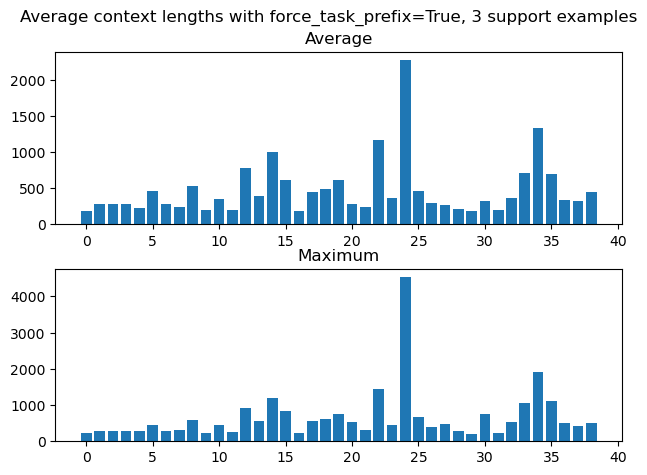

In [28]:
# Barcharts of average and max context lengths per dataset
fig, (avg_ax, max_ax) = plt.subplots(2, 1)
fig.suptitle(f"Average context lengths with force_task_prefix={force_task_prefix}, {n_support} support examples")
fig.tight_layout()

avg_ax.set_title("Average")
avg_ax.bar(range(len(avg_context_lengths)), avg_context_lengths)

max_ax.set_title("Maximum")
max_ax.bar(range(len(max_context_lengths)), max_context_lengths)

fnames = [task_summary["fname"] for task_summary in task_summaries]
for i, fname in enumerate(fnames):
    print(f"{i}={fname}")

In [23]:
print(example_prompts[23])

The following paragraphs each describe a set of three objects arranged in a fixed order. The statements are logically consistent within each paragraph.


In an antique car show, there are three vehicles: a limousine, a truck, and a minivan. The minivan is older than the truck. The limousine is the second-newest. The minivan is the oldest.
Explanation: The limousine is in the middle, so it cannot be the oldest. Thus the oldest must be either the minivan or the truck, and the minivan is older between them.
A fruit stand sells three fruits: cantaloupes, watermelons, and mangoes. The mangoes are the cheapest. The cantaloupes are the second-most expensive. The mangoes are the cheapest.
Explanation: It's a premise that the mangoes are the cheapest.
In a golf tournament, there were three golfers: Amy, Ana, and Joe. Amy finished below Ana. Ana finished below Joe. Amy finished last.
Explanation: Because Ana finished below Joe, Joe cannot be last. Between Amy and Ana, Amy finished below, so Amy 

In [6]:
print("Average number of tokens per element over all datasets...")
for i, key in enumerate(task_summaries[0]["avg_num_tokens"].keys()):
    values = [task_summary["avg_num_tokens"][key] for task_summary in task_summaries]
    print(f"{key}: {np.average(values):0.1f} tokens")

Average number of tokens per element over all datasets...
task_prefix: 16.8 tokens
zeroshot_descriptions: 28.4 tokens
zeroshot_nondescriptions: 30.8 tokens
target: 3.2 tokens
input: 52.7 tokens
explanation: 52.7 tokens
true_nonexplanation: 21.4 tokens


0=analytic_entailment.json
1=arithmetic_2_digit_multiplication.json
2=arithmetic_3_digit_division.json
3=arithmetic_3_digit_subtraction.json
4=cause_and_effect_two_sentences.json
5=color_RGB.json
6=common_morpheme.json
7=crash_blossom.json
8=crass_ai.json
9=cs_algorithms_valid_parentheses.json
10=disambiguation_q.json
11=empirical_judgments.json
12=english_proverbs.json
13=epistemic_reasoning.json
14=evaluating_information_essentiality.json
15=fantasy_reasoning.json
16=figure_of_speech_detection.json
17=goal_step_wikihow_goal_inference.json
18=goal_step_wikihow_step_inference.json
19=identify_odd_metaphor.json
20=implicatures.json
21=irony_identification.json
22=logical_args.json
23=logical_deduction_three_objects.json
24=logic_grid_puzzle.json
25=mathematical_induction.json
26=metaphor_boolean.json
27=navigate.json
28=nonsense_words_grammar.json
29=odd_one_out.json
30=penguins_in_a_table.json
31=phrase_relatedness.json
32=physical_intuition.json
33=physics_mc.json
34=play_dialog_same_

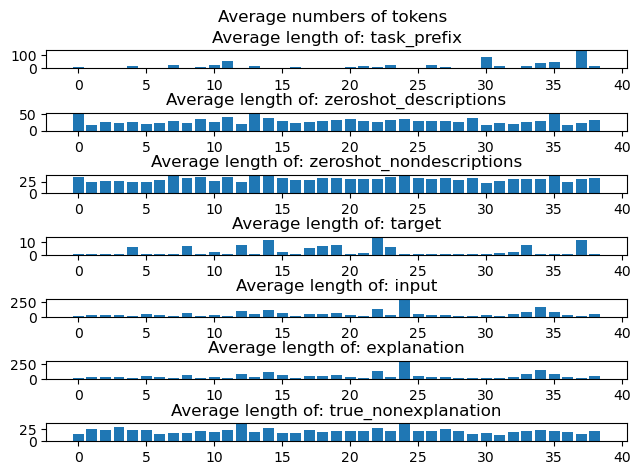

In [7]:
# Barcharts of average element lengths per dataset
fig, axes = plt.subplots(7, 1)
fig.suptitle("Average numbers of tokens")
fig.tight_layout()
fnames = [task_summary["fname"] for task_summary in task_summaries]
for i, key in enumerate(task_summaries[0]["avg_num_tokens"].keys()):
    values = [task_summary["avg_num_tokens"][key] for task_summary in task_summaries]
    axes[i].set_title("Average length of: " + key)
    axes[i].bar(range(len(values)), values)

for i, fname in enumerate(fnames):
    print(f"{i}={fname}")

## Summary from this notebook so far
- Data structure is streamlined, we're flexible in choosing tasks
- We only have 15 CoTs per task
- For 0-shot most tasks fit in less than 100-200 tokens
- For n-shot we need roughly n-times that context length

## Other findings
- It seems that no other papers have used these CoT's for fine-tuning
- There is another dataset "natural-instructions" with CoTs

## Next steps
- Illustrate 2 paths:
    - Use CoTs for prompts, fine-tune on whole BigBench
    - Fine-tune on CoTs and answers
- Experiment MVP ideas
    - bloom because it has many sizes and is not fine-tuned, so the effect should be visible 
    - 3-shot with balanced-shuffled CoTs in support, fine-tune only on answer from bigbench, 512 context length, almost any task
    - 0-shot train on 15 CoTs almost any task
    - 0-shot train on all tasks with each 15 CoTs
- Read rest of original paper
- Investigate "natural-instructions" dataset, maybe there's more CoTs
- Check if there's tasks similar enough that we might combine trainingdata to get e.g. 30 CoTs
- Design and implement MVP for dataloader and dataset classes
- ?